# Dogs vs. Cats dataset - Convnet

## What will be doing?

- Training an small model from scratch
- Doing feature extraction using pretrained layers
- Fine-Tune the pretrained model

## Downloading the data

Data is available [here](https://www.kaggle.com/c/dogs-vs-cats/data).

In [1]:
from pathlib import Path
import shutil

In [2]:
ORIGINAL_DATASET_DIR = Path('../datasets/dogs_cats')
DATA_DIR = Path('data/dogs_cat_dataset')
REGENERATE_DATA = False

In [3]:
def move_data(fnames, dst_base_dir):
    for fname in fnames:
        src = ORIGINAL_DATASET_DIR.joinpath(fname)
        dst = dst_base_dir.joinpath(fname)
        shutil.copy(src, dst)

def maybe_create_dir(dir_):
    if not dir_.exists():
        dir_.mkdir()
        
train_dir = DATA_DIR.joinpath('train'); maybe_create_dir(train_dir)
validation_dir = DATA_DIR.joinpath('validation'); maybe_create_dir(validation_dir)
test_dir = DATA_DIR.joinpath('test'); maybe_create_dir(test_dir)

train_cats_dir = train_dir.joinpath('cats'); maybe_create_dir(train_cats_dir)
train_dogs_dir = train_dir.joinpath('dogs'); maybe_create_dir(train_dogs_dir)

validation_cats_dir = validation_dir.joinpath('cats'); maybe_create_dir(validation_cats_dir)
validation_dogs_dir = validation_dir.joinpath('dogs'); maybe_create_dir(validation_dogs_dir)

test_cats_dir = test_dir.joinpath('cats'); maybe_create_dir(test_cats_dir)
test_dogs_dir = test_dir.joinpath('dogs'); maybe_create_dir(test_dogs_dir)

In [4]:
if REGENERATE_DATA:
    train_cat_names = ['cat.{}.jpg'.format(i) for i in range(1000)]
    val_cat_names = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
    test_cat_names = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]

    move_data(train_cat_names, train_cats_dir)
    move_data(val_cat_names, validation_cats_dir)
    move_data(test_cat_names, test_cats_dir)

    train_dog_names = ['dog.{}.jpg'.format(i) for i in range(1000)]
    val_dog_names = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
    test_dog_names = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]

    move_data(train_dog_names, train_dogs_dir)
    move_data(val_dog_names, validation_dogs_dir)
    move_data(test_dog_names, test_dogs_dir)

## Frame the problem

Balanced binary-classification

## Build a simple model

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [6]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preparation steps

1. Read the pictures files
2. Decode the JPEG content to RGB grids of pixels
3. Convert these into floating-point tensors
4. Rescale the pixel values to the [0, 1] interval (as you know, neural networks prefer small values)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    str(train_dir),
    target_size=(150, 150),
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    str(validation_dir),
    target_size=(150, 150),
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
for data_batch, labels_batch in train_generator:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


## Train the model

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=30)

Epoch 1/10
63/63 [==============================] - 8s 133ms/step - loss: 0.1851 - acc: 0.9330 - val_loss: 0.6446 - val_acc: 0.7290
Epoch 2/10
63/63 [==============================] - 8s 125ms/step - loss: 0.1616 - acc: 0.9450 - val_loss: 0.6412 - val_acc: 0.7500
Epoch 3/10
63/63 [==============================] - 8s 122ms/step - loss: 0.1570 - acc: 0.9465 - val_loss: 0.6623 - val_acc: 0.7420
Epoch 4/10
63/63 [==============================] - 8s 124ms/step - loss: 0.1337 - acc: 0.9540 - val_loss: 0.7394 - val_acc: 0.7380
Epoch 5/10
63/63 [==============================] - 7s 116ms/step - loss: 0.1312 - acc: 0.9545 - val_loss: 0.6622 - val_acc: 0.7390
Epoch 6/10
63/63 [==============================] - 8s 120ms/step - loss: 0.1145 - acc: 0.9640 - val_loss: 0.7145 - val_acc: 0.7370
Epoch 7/10
63/63 [==============================] - 8s 133ms/step - loss: 0.1022 - acc: 0.9675 - val_loss: 0.7049 - val_acc: 0.7300
Epoch 8/10
63/63 [==============================] - 9s 138ms/step - loss: 0.

In [10]:
model.save('cats_and_dogs_small_1.h5')

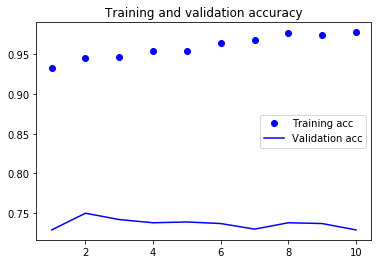

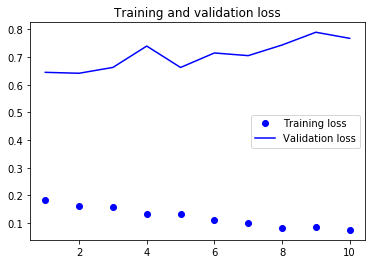

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristics of overfitting. While loss and accuracy decrease and increase respectively on the training set, on the validation set they don't improve since the 5th epoch. 

## Avoid the overfitting using data augmentation

In [14]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Take a look to the generated images

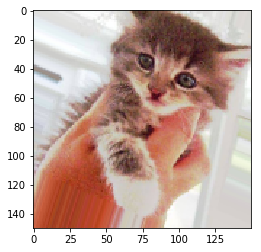

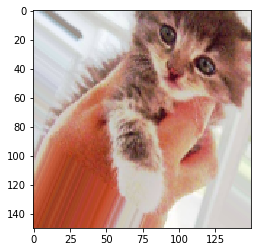

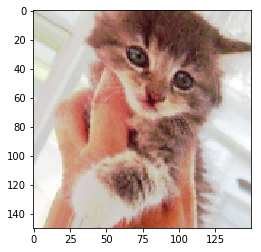

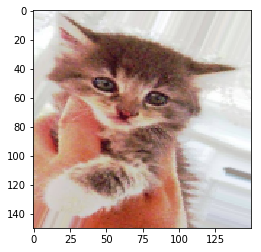

In [15]:
from tensorflow.keras.preprocessing import image 

fnames = [ cat for cat in DATA_DIR.joinpath('train', 'cats').iterdir() ]

img_path = fnames[3]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

Also we need to add a dropout layer. Although we can generate infinite images using `ImageDataGenerator` we cannot create new information, we are only remixing existing information, so for this reason this may not be enough to fight against overfit. 

## Generate new data pipeline & model

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    rescale=1./255.,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    str(train_dir),
    batch_size=32,
    target_size=(150, 150),
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    str(validation_dir),
    batch_size=32,
    target_size=(150, 150),
    class_mode='binary')

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(.5),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/100
63/63 [==============================] - 20s 324ms/step - loss: 0.7646 - acc: 0.5060 - val_loss: 0.6925 - val_acc: 0.5000
Epoch 2/100
63/63 [==============================] - 18s 287ms/step - loss: 0.6932 - acc: 0.5065 - val_loss: 0.7007 - val_acc: 0.5000
Epoch 3/100
63/63 [==============================] - 18s 281ms/step - loss: 0.6931 - acc: 0.5325 - val_loss: 0.6747 - val_acc: 0.5260
Epoch 4/100
63/63 [==============================] - 19s 302ms/step - loss: 0.6858 - acc: 0.5710 - val_loss: 0.6623 - val_acc: 0.5530
Epoch 5/100
63/63 [==============================] - 18s 286ms/step - loss: 0.6552 - acc: 0.6060 - val_loss: 0.6676 - val_acc: 0.6190
Epoch 6/100
63/63 [==============================] - 17s 275ms/step - loss: 0.6520 - acc: 0.6325 - val_loss: 0.6438 - val_acc: 0.61

Epoch 36/100
63/63 [==============================] - 15s 238ms/step - loss: 0.4921 - acc: 0.7650 - val_loss: 0.4488 - val_acc: 0.8020
Epoch 37/100
63/63 [==============================] - 15s 232ms/step - loss: 0.4848 - acc: 0.7795 - val_loss: 0.4813 - val_acc: 0.7810
Epoch 38/100
63/63 [==============================] - 15s 233ms/step - loss: 0.4897 - acc: 0.7780 - val_loss: 0.4502 - val_acc: 0.7940
Epoch 39/100
63/63 [==============================] - 15s 237ms/step - loss: 0.4994 - acc: 0.7665 - val_loss: 0.4293 - val_acc: 0.8020
Epoch 40/100
63/63 [==============================] - 14s 229ms/step - loss: 0.5015 - acc: 0.7565 - val_loss: 0.5569 - val_acc: 0.6930
Epoch 41/100
63/63 [==============================] - 15s 232ms/step - loss: 0.4764 - acc: 0.7800 - val_loss: 0.4024 - val_acc: 0.8190
Epoch 42/100
63/63 [==============================] - 15s 242ms/step - loss: 0.4845 - acc: 0.7765 - val_loss: 0.4537 - val_acc: 0.7900
Epoch 43/100
63/63 [==============================] - 1

Epoch 74/100
63/63 [==============================] - 15s 237ms/step - loss: 0.4214 - acc: 0.8215 - val_loss: 0.7204 - val_acc: 0.7310
Epoch 75/100
63/63 [==============================] - 15s 235ms/step - loss: 0.4294 - acc: 0.8150 - val_loss: 0.4048 - val_acc: 0.8260
Epoch 76/100
63/63 [==============================] - 15s 234ms/step - loss: 0.3944 - acc: 0.8250 - val_loss: 0.4446 - val_acc: 0.7960
Epoch 77/100
63/63 [==============================] - 15s 241ms/step - loss: 0.3965 - acc: 0.8270 - val_loss: 0.5867 - val_acc: 0.7670
Epoch 78/100
63/63 [==============================] - 15s 234ms/step - loss: 0.4082 - acc: 0.8185 - val_loss: 0.4232 - val_acc: 0.8110
Epoch 79/100
63/63 [==============================] - 15s 231ms/step - loss: 0.4107 - acc: 0.8095 - val_loss: 0.3748 - val_acc: 0.8410
Epoch 80/100
63/63 [==============================] - 15s 231ms/step - loss: 0.3862 - acc: 0.8280 - val_loss: 0.4179 - val_acc: 0.8210
Epoch 81/100
63/63 [==============================] - 1

## Using VGG16 pretrained model

In [17]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [18]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Completely independent classifier

In [19]:
import numpy as np

datagen = ImageDataGenerator(rescale=1./255.)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # VGG16 output shape
    labels = np.zeros(shape=(sample_count,))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features[i * batch_size: (i + 1) * batch_size] = conv_base.predict(inputs_batch)
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(str(train_dir), 2000)
val_features, val_labels = extract_features(str(validation_dir), 1000)
test_features, test_labels = extract_features(str(test_dir), 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# Flatten convulutional layer's output
train_features = train_features.reshape(-1, 4 * 4 * 512)
val_features = val_features.reshape(-1, 4 * 4 * 512)
test_features = test_features.reshape(-1, 4 * 4 * 512)

In [24]:
train_features.shape

(2000, 8192)

In [21]:
model = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(4 * 4 * 512,)),
    layers.Dropout(.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit(train_features, 
                    train_labels, 
                    epochs=30,
                    batch_size=20,
                    validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 626us/sample - loss: 0.5775 - acc: 0.7765 - val_loss: 0.3740 - val_acc: 0.8160
Epoch 2/30
2000/2000 [==============================] - 1s 538us/sample - loss: 0.3489 - acc: 0.8515 - val_loss: 0.2920 - val_acc: 0.8690
Epoch 3/30
2000/2000 [==============================] - 1s 475us/sample - loss: 0.2824 - acc: 0.8855 - val_loss: 0.2514 - val_acc: 0.8980
Epoch 4/30
2000/2000 [==============================] - 1s 490us/sample - loss: 0.2482 - acc: 0.9075 - val_loss: 0.7724 - val_acc: 0.7690
Epoch 5/30
2000/2000 [==============================] - 1s 513us/sample - loss: 0.2228 - acc: 0.9095 - val_loss: 0.2921 - val_acc: 0.8860
Epoch 6/30
2000/2000 [==============================] - 1s 492us/sample - loss: 0.1954 - acc: 0.9185 - val_loss: 0.4115 - val_acc: 0.8460
Epoch 7/30
2000/2000 [==============================] - 1s 475us/sample - loss: 0.1701 - acc: 0.9370 - val_loss: 0.2897 - va

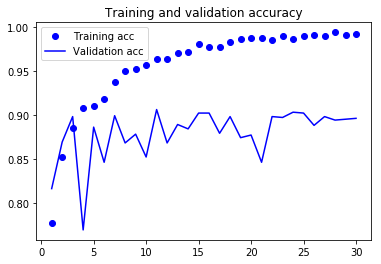

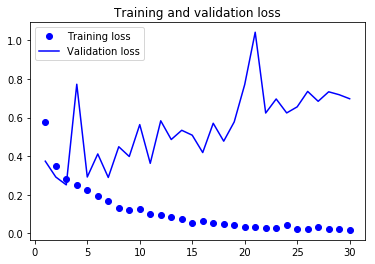

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Extend VGG16 model

In [23]:
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(1, activation='sigmoid')
])

conv_base.trainable = False

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [24]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    rescale=1./255.,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    str(train_dir),
    batch_size=32,
    target_size=(150, 150),
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    str(validation_dir),
    batch_size=32,
    target_size=(150, 150),
    class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

history = model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
63/63 [==============================] - 21s 338ms/step - loss: 1.0404 - acc: 0.6515 - val_loss: 0.4766 - val_acc: 0.7630
Epoch 2/100
63/63 [==============================] - 22s 343ms/step - loss: 0.5349 - acc: 0.7420 - val_loss: 0.3240 - val_acc: 0.8740
Epoch 3/100
63/63 [==============================] - 19s 301ms/step - loss: 0.4865 - acc: 0.7765 - val_loss: 0.2908 - val_acc: 0.8750
Epoch 4/100
63/63 [==============================] - 19s 304ms/step - loss: 0.4476 - acc: 0.7920 - val_loss: 0.2813 - val_acc: 0.8840
Epoch 5/100
63/63 [==============================] - 19s 297ms/step - loss: 0.4288 - acc: 0.8020 - val_loss: 0.3393 - val_acc: 0.8460
Epoch 6/100
63/63 [==============================] - 19s 297ms/step - loss: 0.4194 - acc: 0.8190 - val_loss: 0.3438 - val_acc: 0.8550
Epoch 7/100
63/63 [==============================] - 20s 325ms/step - loss: 0.4055 - acc: 0.8120 - val_loss: 0.3

Epoch 38/100
63/63 [==============================] - 19s 296ms/step - loss: 0.2931 - acc: 0.8740 - val_loss: 0.4403 - val_acc: 0.8400
Epoch 39/100
63/63 [==============================] - 19s 295ms/step - loss: 0.3107 - acc: 0.8700 - val_loss: 0.2470 - val_acc: 0.9110
Epoch 40/100
63/63 [==============================] - 19s 295ms/step - loss: 0.3132 - acc: 0.8705 - val_loss: 0.2549 - val_acc: 0.9000
Epoch 41/100
63/63 [==============================] - 19s 296ms/step - loss: 0.3198 - acc: 0.8635 - val_loss: 0.2928 - val_acc: 0.8780
Epoch 42/100
63/63 [==============================] - 19s 296ms/step - loss: 0.3203 - acc: 0.8645 - val_loss: 0.2559 - val_acc: 0.9080
Epoch 43/100
63/63 [==============================] - 19s 296ms/step - loss: 0.3172 - acc: 0.8675 - val_loss: 0.2583 - val_acc: 0.9030
Epoch 44/100
63/63 [==============================] - 19s 296ms/step - loss: 0.3059 - acc: 0.8755 - val_loss: 0.2557 - val_acc: 0.9110
Epoch 45/100
63/63 [==============================] - 1

63/63 [==============================] - 21s 334ms/step - loss: 0.2959 - acc: 0.8750 - val_loss: 0.2954 - val_acc: 0.8970
Epoch 76/100
63/63 [==============================] - 21s 338ms/step - loss: 0.2948 - acc: 0.8785 - val_loss: 0.2891 - val_acc: 0.9060
Epoch 77/100
63/63 [==============================] - 21s 330ms/step - loss: 0.2793 - acc: 0.8880 - val_loss: 0.2970 - val_acc: 0.9050
Epoch 78/100
63/63 [==============================] - 22s 356ms/step - loss: 0.2910 - acc: 0.8830 - val_loss: 0.2692 - val_acc: 0.9140
Epoch 79/100
63/63 [==============================] - 21s 334ms/step - loss: 0.2863 - acc: 0.8825 - val_loss: 0.2831 - val_acc: 0.9050
Epoch 80/100
63/63 [==============================] - 21s 336ms/step - loss: 0.2834 - acc: 0.8840 - val_loss: 0.2557 - val_acc: 0.9110
Epoch 81/100
63/63 [==============================] - 21s 339ms/step - loss: 0.2866 - acc: 0.8875 - val_loss: 0.2741 - val_acc: 0.9120
Epoch 82/100
63/63 [==============================] - 21s 338ms/step

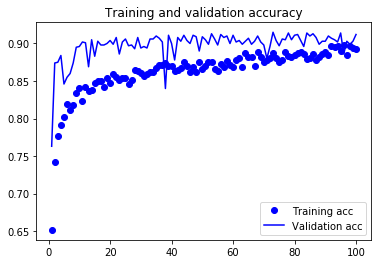

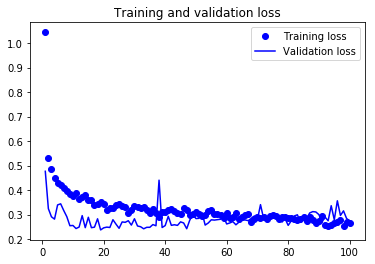

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Fine-Tunning Extend VGG16 model

Fine-Tuning consist of unfreezing a few of the top layers of a frozen model base used for feature extraction, and joinly training both the newly added part of the model (in this case 2 layers of fully connected classifier) and these top layers.

1. Add a custom network on the top of an already-trained base network.
2. Freeze the base network.
3. Train the part ypu added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.

In [26]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1': # From block5_conv1 to the end trainset_trainableainableainableainableainable True 
        set_trainable = True
    
    layer.trainable = set_trainable

We will be using a low learning rate because we want to limit the magnitude of the modifications ypu make to the representation of the three layers you are fine-tuning.

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [34]:
history = model.fit_generator(train_generator, 
                    train_labels, 
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/100
63/63 [==============================] - 23s 362ms/step - loss: 0.2916 - acc: 0.8815 - val_loss: 0.2907 - val_acc: 0.9160
Epoch 2/100
63/63 [==============================] - 21s 339ms/step - loss: 0.2549 - acc: 0.8915 - val_loss: 0.2708 - val_acc: 0.9190
Epoch 3/100
63/63 [==============================] - 21s 339ms/step - loss: 0.2593 - acc: 0.8945 - val_loss: 0.2735 - val_acc: 0.9050
Epoch 4/100
63/63 [==============================] - 21s 340ms/step - loss: 0.2339 - acc: 0.9090 - val_loss: 0.2846 - val_acc: 0.9070
Epoch 5/100
63/63 [==============================] - 21s 340ms/step - loss: 0.2207 - acc: 0.9115 - val_loss: 0.2836 - val_acc: 0.9110
Epoch 6/100
63/63 [==============================] - 21s 340ms/step - loss: 0.2299 - acc: 0.9115 - val_loss: 0.2665 - val_acc: 0.9260
Epoch 7/100
63/63 [==============================] - 21s 340ms/step - loss: 0.2054 - acc: 0.9200 - val_loss: 0.2507 - val_acc: 0.9270
Epoch 8/100
63/63 [==============================] - 21s 340ms

Epoch 39/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0940 - acc: 0.9640 - val_loss: 0.3068 - val_acc: 0.9330
Epoch 40/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0847 - acc: 0.9655 - val_loss: 0.2943 - val_acc: 0.9300
Epoch 41/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0989 - acc: 0.9655 - val_loss: 0.3327 - val_acc: 0.9240
Epoch 42/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0927 - acc: 0.9665 - val_loss: 0.2982 - val_acc: 0.9350
Epoch 43/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0727 - acc: 0.9725 - val_loss: 0.2881 - val_acc: 0.9370
Epoch 44/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0872 - acc: 0.9715 - val_loss: 0.2937 - val_acc: 0.9350
Epoch 45/100
63/63 [==============================] - 22s 347ms/step - loss: 0.0985 - acc: 0.9660 - val_loss: 0.3015 - val_acc: 0.9330
Epoch 46/100
63/63 [==============================] - 2

63/63 [==============================] - 21s 341ms/step - loss: 0.0490 - acc: 0.9815 - val_loss: 0.3201 - val_acc: 0.9370
Epoch 77/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0751 - acc: 0.9775 - val_loss: 0.3290 - val_acc: 0.9330
Epoch 78/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0654 - acc: 0.9795 - val_loss: 0.3631 - val_acc: 0.9340
Epoch 79/100
63/63 [==============================] - 21s 341ms/step - loss: 0.0663 - acc: 0.9805 - val_loss: 0.4744 - val_acc: 0.9220
Epoch 80/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0559 - acc: 0.9820 - val_loss: 0.3489 - val_acc: 0.9350
Epoch 81/100
63/63 [==============================] - 21s 340ms/step - loss: 0.0396 - acc: 0.9845 - val_loss: 0.4626 - val_acc: 0.9290
Epoch 82/100
63/63 [==============================] - 21s 341ms/step - loss: 0.0654 - acc: 0.9740 - val_loss: 0.3530 - val_acc: 0.9360
Epoch 83/100
63/63 [==============================] - 21s 340ms/step

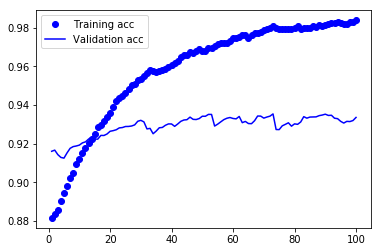

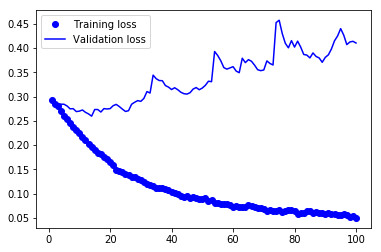

In [39]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Training acc')


plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Validation acc')

plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Training loss')


plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Validation loss')

plt.legend()
plt.show()

### Evaluate with test set

In [41]:
test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size=(150, 150),
                    batch_size=20,
                    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 8s 160ms/step - loss: 0.4490 - acc: 0.9380
Test acc: 0.938
